## Twitter Sentiment Analisys menggunakan metode A NAIVE BAYES CLASSIFIER (NBC)
### 1.Case Folding:
Case folding dilakukan untuk
mengubah setiap karakter didalam teks menjadi huruf
kecil. Tidak semua kata dalam teks konsisten dalam
penggunaan huruf kapital disinilah tujuan dilakukan case
folding untuk mengkonversi setiap karakter dalam kata
menjadi huruf kecil.
### 2.Tokenisasi: 
Tokenisasi merupakan proses
pemecahan kata pada suatu teks ke dalam satuan kata.
Tokenisasi dilakukan untuk menghasilkan kumpulan kata
yang berdiri sendiri, tokenisasi memecah teks yang
semula berupa kalimat menjadi kata-kata. tokenisasi
menghilangkan delimeter seperti titik (.), koma (,), spasi,
dan karakter angka yang ada pada kata tersebut.
Dalam penelitian ini tokenisasi dilakukan untuk
memecah kata, serta melakukan penghapusan delimeter
beserta karakter angka bersama tweet entity seperti
hashtag, retweet dan mention.
### 3.Filtering: 
Filtering merupakan proses dalam text
preprocessing setelah tokenisasi, filtering dilakukan untuk
untuk mengambil kata penting hasil tokenisasi. Pada tahap
filtering kata akan ditentukan apakah akan digunakan atau 
dibuang. Proses dalam filtering dalam membuang katakata yang tidak digunakan atau stopword terdapat dalam
bag of words stoplist.
Stopword merupakan daftar kata-kata yang tidak
mempresentasikan isi dari suatu dokumen teks, stopword
dilakukan untuk meghilangkan kata atau term yang tidak
memiliki arti. Daftar stoplist akan dibuat sebelum
melakukan proses stopword removal, jika kata-kata
terdapat dalam daftar stoplist, maka kata tersebut akan
dihapus, sehingga kata-kata yang tersisa akan dianggap
kata yang mencirikan isi suatu dokumen.
### 4.Stemming: 
Stemming merupakan proses mengubah
kata menjadi bentuk dasarnya. Stemming dilakukan untuk
meyeragamkan bentuk kata. Tujuan dari proses stemming
adalah menghilangkan imbuhan-imbuhan baik itu berupa
prefiks, sufiks, maupun konfiks yang ada pada setiap kata. 
Stemming dalam penelitian ini dilakukan berdasarkan
aturan morfologi bahasa Indonesia.


### berikut adalah langka-langkahnya:

### 1.Install Library(module) yang dibutuhkan

In [ ]:
# %pip install tweepy
# %pip install Sastrawi
# %pip install numpy
# %pip install sklearn
# %pip install textblob
# %pip install pandas

### 2. Ambil Data Tweets

In [8]:
import tweepy 

BEARERTOKEN = 'AAAAAAAAAAAAAAAAAAAAAJQrYQEAAAAA1BtlexYIrHRZvqkz6TEOraEC%2B0k%3D5cOp6U7ytEMpcTDctDQWVl6HFd0Y28pxhDnTGyHA9KiiC1MVCF'

client = tweepy.Client(bearer_token=BEARERTOKEN)

query = '"Ruang Guru" lang:id'

# get data max 100
responses = client.search_recent_tweets(query=query, max_results=100, tweet_fields=['created_at'])
tweet100 = [tweet for tweet in responses.data]

# get max 1000
tweettexts = [tweet.text for tweet in tweepy.Paginator(client.search_recent_tweets, query=query, max_results=100).flatten(limit=1000)]


### 3. Case Folding

In [ ]:
tweettexts = [tweet.lower() for tweet in tweettexts]
tweettexts

### 4. Tokenisasi

In [ ]:
tweettoken = []
for tweet in tweettexts:
    for tw in tweet.split():
        tweettoken.append(tw)
tweettoken

### 4. Filtering

In [42]:
import re

def cleaning(tweet):
    # remove old style retweet text "RT"
    new_tweet = re.sub(r'rt', '', tweet)
    
    # hilangkan username
    new_tweet = re.sub(r'^@[\w\d]', '', new_tweet)
    
    
    # remove hyperlinks
    new_tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', new_tweet)

    # remove hashtags
    # only removing the hash # sign from the word
    new_tweet = re.sub("[^A-Za-z" "]+", " ", new_tweet)
    
    return new_tweet.strip()

cleantweets = [cleaning(tweet) for tweet in tweettoken]
cleantweets

['reasuremenfess',
 'aru',
 'jadi',
 'inget',
 'akun',
 'ruang',
 'guru',
 'pacar',
 'haruto',
 'blm',
 'diganti tutor',
 'nya',
 'manggi',
 'pacar',
 'haruto',
 'jugaa',
 'onvomf',
 'nama',
 'hewan',
 'dragon',
 'gue',
 'yg',
 'dah',
 'mati',
 'soalnya',
 'gprnah',
 'buka',
 'ruang',
 'guru',
 'buat',
 'belajar',
 'lagi',
 '',
 'amenterbang',
 'orksfess',
 'jangankan',
 'nakes',
 'murid',
 'julidin',
 'gurunya',
 'aja',
 'udah',
 'biasa',
 'yg',
 'masalah',
 'adalah',
 'ketika',
 'julidan',
 'tersebut',
 'udah',
 'masuk',
 'ke',
 'orksfess',
 'blm',
 'tau',
 'aja',
 'julidnya',
 'di',
 'ruang',
 'guru',
 'kyk',
 'gmn',
 '',
 '',
 'amenterbang',
 'orksfess',
 'jangankan',
 'nakes',
 'murid',
 'julidin',
 'gurunya',
 'aja',
 'udah',
 'biasa',
 'yg',
 'masalah',
 'adalah',
 'ketika',
 'julidan',
 'tersebut',
 'udah',
 'masuk',
 'ke',
 'uro',
 'unu k',
 'egblgnunfaedh',
 'kalo',
 'masih',
 'ga',
 'paham',
 'coba',
 'tanya',
 'ke',
 'admin',
 'ruang',
 'guru',
 'kali',
 'aja',
 'dapet',
 '

### 4. Stemming

In [6]:
# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stem
stemmedtexts   = [stemmer.stem(text) for text in cleantweets]

## Labeling

In [ ]:
pos_kata = open('kata_positif_2.txt', 'r').readlines()
neg_kata = open('kata_negatif_2.txt', 'r').readlines()

sentiments = [] #Membuat sebuah list menyimpan nilai sentiment

#list kata-kata negasi
negasi = open('negasi.txt', 'r').readlines()

#fungsi menghitung sentiment setiap tweet
for ind,stemmed in enumerate(stemmedtexts):
    print(stemmed.strip())
    tweets = stemmed.strip().split() #tokenization
    # print(tweets)
    
    count_p = 0 #nilai positif
    count_n = 0 #nilai negatif
    count_ne = 0 #nilai netral
    
    for tweet in tweets:
        for kata_pos in pos_kata:
            if kata_pos.strip().lower() == tweet.lower():
                #ind-1 digunakan untuk mencari nilai index sebelum index positifnya
                #aku menyukai bola
                if stemmedtexts[ind-1] in negasi:
                    print(stemmedtexts[ind-1], kata_pos, ['negatif'])
                    count_n += 1
                else:
                    print(kata_pos, ['positif'])
                    count_p += 1

        for kata_neg in neg_kata:
            if kata_neg.strip().lower() == tweet.lower():
                if stemmedtexts[ind-1] in negasi:
                    print(stemmedtexts[ind-1], kata_neg, ['positif'])
                    count_p += 1
                else:
                    print(kata_neg, ['negatif'])
                    count_n += 1
        
        for kat_pos_neg in (pos_kata + neg_kata):
            if kat_pos_neg.strip().lower() != tweet.lower():
                print(stemmedtexts[ind-1], kat_pos_neg, ['netral'])
                count_ne += 1
    
    print("positif: "+str(count_p))
    print("negatif: "+str(count_n))
    print("netral: "+str(count_ne))
    sentiments.append(count_p - count_n)

Matplotlib is building the font cache; this may take a moment.


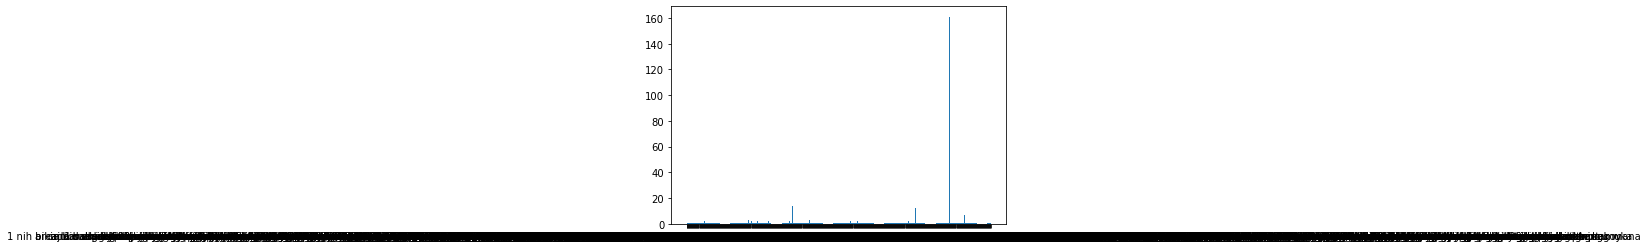

In [ ]:
# Append Pandas DataFrame to Existing CSV File
# importing pandas module
import pandas as pd

# data of Player and their performance
data = {
	'Name': ['Hardik', 'Pollard', 'Bravo'],
	'Run': [50, 63, 15],
	'Wicket': [0, 2, 3], 
	'Catch': [4, 2, 1]
}

# Make data frame of above data
df = pd.DataFrame(data)

# append data frame to CSV file
df.to_csv('GFG.csv', mode='a', index=False, header=False)

# print message
print("Data appended successfully.")
